In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

num_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes

for i, example in enumerate(training_set.take(5)):

  def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 749s 9s/step - loss: 0.9770 - accuracy: 0.6362 - val_loss: 0.4529 - val_accuracy: 0.8438
Epoch 2/6
81/81 [==============================] - 723s 9s/step - loss: 0.4119 - accuracy: 0.8676 - val_loss: 0.3559 - val_accuracy: 0.8801
Epoch 3/6
81/81 [==============================] - 724s 9s/step - loss: 0.3244 - accuracy: 0.9020 - val_loss: 0.3172 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 724s 9s/step - loss: 0.2762 - accuracy: 0.9217 - val_loss: 0.3101 - val_accuracy: 0.8910
Epoch 5/6
81/81 [==============================] - 724s 9s/step - loss: 0.2452 - accuracy: 0.9300 - val_loss: 0.2892 - val_accuracy: 0.8965
Epoch 6/6
81/81 [==============================] - 724s 9s/step - loss: 0.2034 - accuracy: 0.9471 - val_loss: 0.2874 - val_accuracy: 0.8974


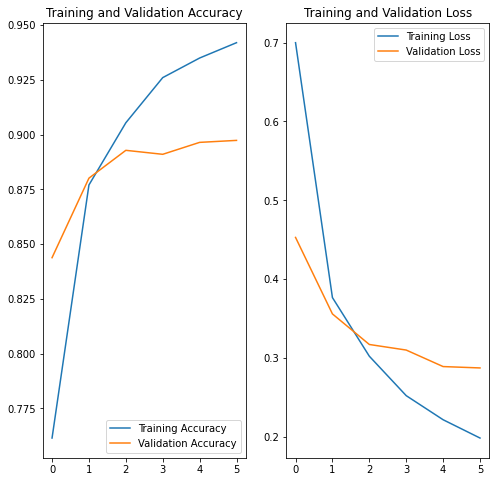

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [ ]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['roses' 'dandelion' 'tulips' 'roses' 'sunflowers' 'roses' 'sunflowers'
 'daisy' 'tulips' 'dandelion' 'tulips' 'daisy' 'roses' 'sunflowers'
 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips'
 'sunflowers' 'sunflowers' 'daisy' 'daisy' 'roses' 'tulips' 'tulips'
 'dandelion' 'tulips' 'sunflowers' 'tulips' 'sunflowers']


In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [4 0 2 4 3 2 3 1 2 0 2 1 4 3 3 3 4 3 0 2 3 3 1 1 4 2 2 0 2 3 2 3]
Predicted labels:  [4 0 2 4 3 4 3 1 2 0 2 1 4 3 3 3 4 3 0 2 3 3 1 1 4 2 2 0 2 3 2 3]


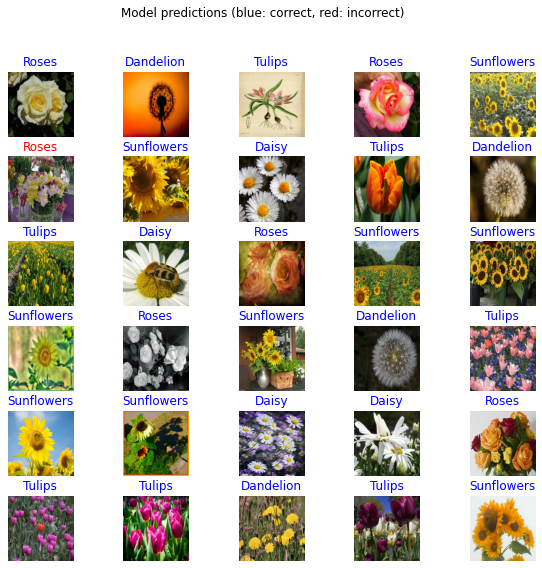

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

In [ ]:
!ls

In [ ]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
(abs(result_batch - reloaded_result_batch)).max()

In [ ]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

In [ ]:
!ls {export_path_sm}

In [ ]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [ ]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [ ]:
(abs(result_batch - reload_sm_result_batch)).max()